In [1]:
!pip install kaggle

In [2]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
!kaggle datasets download -d prathmeshgodse/food101-zip -p /content/food101 --unzip

Dataset URL: https://www.kaggle.com/datasets/prathmeshgodse/food101-zip
License(s): unknown
100% 18.6G/18.6G [06:58<00:00, 25.5MB/s]
100% 18.6G/18.6G [06:58<00:00, 47.8MB/s]


### **Preparation For Dataset food101**

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Path ke dataset
dataset_dir = "/content/food101/food-101/"

IMG_SIZE = 224
BATCH_SIZE = 32

# Load training dataset
ds_train = image_dataset_from_directory(
    dataset_dir + "train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    label_mode="categorical"  # Bisa "categorical", "binary", atau "int"
)

# Load test dataset
ds_test = image_dataset_from_directory(
    dataset_dir + "test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    label_mode="categorical"
)

# Cek beberapa sampel
for images, labels in ds_train.take(1):
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)

class_labels = ds_train.class_names

Found 101000 files belonging to 101 classes.
Found 101000 files belonging to 101 classes.
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 101)
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_sou

Data augmentation sangat penting untuk memperkaya dataset dan membantu model dalam belajar berbagai variasi dari gambar. Beberapa teknik augmentasi yang bisa dicoba adalah:

Rotasi, zoom, flip, dan shear
Random contrast, brightness, dan saturation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Terapkan augmentasi data pada training data
datagen.fit(ds_train)

### **Build a CNN Model with Learning Transfer**

Jika model Anda memiliki arsitektur yang cukup sederhana, Anda bisa mencoba model yang lebih dalam atau menggunakan pretrained models seperti ResNet50, VGG16, atau EfficientNet yang sudah terlatih pada dataset besar dan kemudian disesuaikan dengan dataset Anda.

Contoh penggunaan Transfer Learning dengan model EfficientNet

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained EfficientNetB0 tanpa lapisan akhir
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Bekukan bobot pre-trained model

# Tambahkan lapisan tambahan untuk klasifikasi makanan
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dense(len(class_labels), activation="softmax"),
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Tampilkan arsitektur model
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback untuk menghentikan training jika loss tidak membaik
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Simpan model terbaik
model_checkpoint = ModelCheckpoint("best_food101_model.keras", save_best_only=True, save_format="keras")

# Latih model
history = model.fit(ds_train, validation_data=ds_test, epochs=20, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4375 - loss: 2.3969

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 520s 157ms/step - accuracy: 0.4375 - loss: 2.3968 - val_accuracy: 0.6785 - val_loss: 1.2499
Epoch 2/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6037 - loss: 1.5350

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 556s 160ms/step - accuracy: 0.6037 - loss: 1.5350 - val_accuracy: 0.7070 - val_loss: 1.1206
Epoch 3/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6171 - loss: 1.4706

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 553s 157ms/step - accuracy: 0.6171 - loss: 1.4706 - val_accuracy: 0.7209 - val_loss: 1.0608
Epoch 4/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6243 - loss: 1.4514

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 505s 158ms/step - accuracy: 0.6243 - loss: 1.4514 - val_accuracy: 0.7306 - val_loss: 1.0195
Epoch 5/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6266 - loss: 1.4346

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 494s 156ms/step - accuracy: 0.6266 - loss: 1.4346 - val_accuracy: 0.7349 - val_loss: 1.0019
Epoch 6/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6298 - loss: 1.4230

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 507s 157ms/step - accuracy: 0.6298 - loss: 1.4230 - val_accuracy: 0.7401 - val_loss: 0.9804
Epoch 7/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6293 - loss: 1.4234

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 452s 141ms/step - accuracy: 0.6293 - loss: 1.4234 - val_accuracy: 0.7429 - val_loss: 0.9653
Epoch 8/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6337 - loss: 1.4180

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 556s 158ms/step - accuracy: 0.6337 - loss: 1.4180 - val_accuracy: 0.7437 - val_loss: 0.9618
Epoch 9/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6318 - loss: 1.4192

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 494s 156ms/step - accuracy: 0.6318 - loss: 1.4192 - val_accuracy: 0.7465 - val_loss: 0.9478
Epoch 10/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6301 - loss: 1.4401

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 467s 145ms/step - accuracy: 0.6301 - loss: 1.4401 - val_accuracy: 0.7457 - val_loss: 0.9462
Epoch 11/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6311 - loss: 1.4246

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 499s 158ms/step - accuracy: 0.6311 - loss: 1.4246 - val_accuracy: 0.7489 - val_loss: 0.9371
Epoch 12/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6338 - loss: 1.4221

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 495s 156ms/step - accuracy: 0.6338 - loss: 1.4221 - val_accuracy: 0.7509 - val_loss: 0.9328
Epoch 13/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 457s 145ms/step - accuracy: 0.6341 - loss: 1.4116 - val_accuracy: 0.7509 - val_loss: 0.9300
Epoch 14/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6335 - loss: 1.4078

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 500s 144ms/step - accuracy: 0.6335 - loss: 1.4078 - val_accuracy: 0.7523 - val_loss: 0.9272
Epoch 15/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6326 - loss: 1.4175

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 500s 158ms/step - accuracy: 0.6326 - loss: 1.4175 - val_accuracy: 0.7502 - val_loss: 0.9262
Epoch 16/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 497s 157ms/step - accuracy: 0.6333 - loss: 1.4130 - val_accuracy: 0.7497 - val_loss: 0.9269
Epoch 17/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6330 - loss: 1.4249

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 512s 160ms/step - accuracy: 0.6330 - loss: 1.4249 - val_accuracy: 0.7515 - val_loss: 0.9210
Epoch 18/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6334 - loss: 1.4229

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 514s 145ms/step - accuracy: 0.6334 - loss: 1.4229 - val_accuracy: 0.7524 - val_loss: 0.9192
Epoch 19/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 518s 150ms/step - accuracy: 0.6344 - loss: 1.4204 - val_accuracy: 0.7521 - val_loss: 0.9193
Epoch 20/20
3156/3157 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6317 - loss: 1.4263

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 537s 161ms/step - accuracy: 0.6317 - loss: 1.4263 - val_accuracy: 0.7522 - val_loss: 0.9184


In [17]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3157/3157 ━━━━━━━━━━━━━━━━━━━━ 230s 71ms/step - accuracy: 0.6510 - loss: 1.2966
Test Accuracy: 65.01%


## **Predicted the Image**

False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


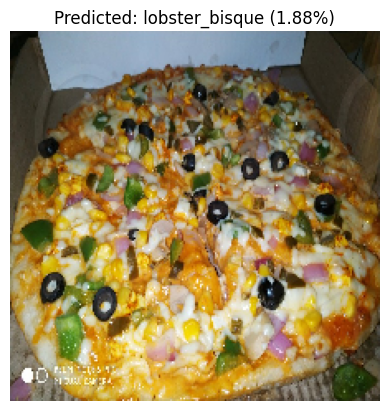

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

def get_class_labels_from_directory(directory):
    # Ambil nama subfolder sebagai label
    return sorted([folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))])

def predict_image(image_path, class_labels):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    print(hasattr(model, 'class_names'))
    prediction = model.predict(image_array)
    predicted_index = np.argmax(prediction)
    probability = np.max(prediction) * 100
    predicted_label = class_labels[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} ({probability:.2f}%)")
    # plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


# model = tf.keras.models.load_model("/content/best_food101_model.h5")

# Cek apakah model memiliki class_names
if hasattr(model, 'class_names'):
    class_labels = model.class_names
else:
    # Jika tidak ada, ambil class labels dari direktori dataset
    class_labels = get_class_labels_from_directory("/content/food101/food-101/train")


predict_image("/content/5cb72ada016b64da8adc7a52.w800.jpg", class_labels)
